# Measure Performance of Your Own Neural Network Model

This is continual series of assigment 

You can extend your own code from asssigment M3.1

#### Note. I changed the previous criteria for significant increase / decrease into 0.2 std from 1.0 std to avoid the safe answer


- Exercise1 Performance Evaluation for Trinary Classification Model
- Exercise2 Performance Evaluation for Return Prediction Model

# Exercise1  Performance Evaluation for Trinary Classification Model



### Data Download at: https://drive.google.com/open?id=1thjGhgnAm5k1zuSiWhGmlUJzBXM3IECi

This exercise is a little bit long exercise, that should give you an idea of a real world scenario. Feel free to look at the solution if you feel lost.

#### Requirements
1. Comparing Accuracy for both Train and Validation set data
  - Compare accurcacy according to the below materials
  - Visualize training history
  - Check genelarization of your model
  - Refer
    - https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589
  - Visualization Hint
    - https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
2. Measure Model Accuracy for Classification Problem
  - Now we are going to evaluate our model 
  - Accuracy, Recall, F1 Score based on Confusion Matrix
  - Refer definition of each scores
    - Confusion matrix https://en.wikipedia.org/wiki/Confusion_matrix
    - Confusion matrix in Korean https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/
  - Hint
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
    
3. Measure Test Set Return based on the Simplest Strategy
  - Condition
    - Initial budget = 100
  - Strategy
    - If we predict up, then buy or hold (if we already bought)
    - If we predict down or no change then sell (if we already bought) or do nothing 
  - Draw your return

#### Procedures
- Preprocessing
  1. Data Import and Create Balanced Panel
  2. Create Target Variable
  3. Train / Test Split
  4. Create Sequences
  

- Training / Predicting Model
  1. Model Build
  2. Model Train
  3. Prediction
  4. Evaluation <- this assignment implement it

## Preprocessing

### 1. Data Import and Create Balanced Panel

In [0]:
%matplotlib inline

In [109]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DATA_PATH = "/content/gdrive/My Drive/Lecture/StudyPie/Data/"

In [111]:
!ls "/content/gdrive/My Drive/Lecture/StudyPie/Data/"

256x2-CNN.model  crypto_data.zip  M2_1_y.pickle  PetImages.zip
CoinOne		 log		  __MACOSX	 simple_rnn_model.h5
crypto_data	 M2_1_X.pickle	  PetImages


In [0]:
# Unzip Data
# It will take more than 5 min
import zipfile
import io

zf = zipfile.ZipFile(DATA_PATH+"crypto_data.zip", "r")
zf.extractall(DATA_PATH)

In [0]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "LTC-USD"

In [8]:
import pandas as pd

main_df = pd.DataFrame() # begin empty

ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]  # the 4 ratios we want to consider

for ratio in ratios:  # begin iteration
    print(ratio)
    dataset = DATA_PATH+f'crypto_data/{ratio}.csv'  # get the full path to the file.
    df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file

    # rename volume and close to include the ticker so we can still which close/volume is which:
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)

    df.set_index("time", inplace=True)  # set time as index so we can join them on this shared time
    df = df[[f"{ratio}_close", f"{ratio}_volume"]]  # ignore the other columns besides price and volume

    if len(main_df)==0:  # if the dataframe is empty
        main_df = df  # then it's just the current df
    else:  # otherwise, join this data to the main one
        main_df = main_df.join(df)

main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)
print(main_df.head())  # how did we do??

BTC-USD
LTC-USD
BCH-USD
ETH-USD
            BTC-USD_close  BTC-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1528968720    6487.379883        7.706374      96.660004      314.387024   
1528968780    6479.410156        3.088252      96.570000       77.129799   
1528968840    6479.410156        1.404100      96.500000        7.216067   
1528968900    6479.979980        0.753000      96.389999      524.539978   
1528968960    6480.000000        1.490900      96.519997       16.991997   

            BCH-USD_close  BCH-USD_volume  ETH-USD_close  ETH-USD_volume  
time                                                                      
1528968720     870.859985       26.856577      486.01001       26.019083  
1528968780     870.099976        1.124300      486.00000        8.449400  
1528968840     870.789978        1.749862      485.75000       26.994646  
1528968900     870.000000        1.680500      486.00000    

### 2. Create Target Variable

In [0]:
SIGNIFICANT_CRITERIA = 0.2   # 0.2 std criteria
 
currency_targets = ["BTC"]

for currency_target in currency_targets:
    main_df[currency_target+'-USD-TARGET'] = main_df[currency_target+'-USD_close'].shift(-FUTURE_PERIOD_PREDICT )
    main_df[currency_target+'-USD-TARGET-RETURN'] = (main_df[currency_target+'-USD-TARGET'] 
                                                                - main_df[currency_target+'-USD_close'])/main_df[currency_target+'-USD_close']

In [0]:
import numpy as np

def classify_trinary(values):
    gp_std = np.std(values)

    target = []
    for value in values:
        if SIGNIFICANT_CRITERIA*gp_std < value: # significant increase
            target.append(2)
        elif -SIGNIFICANT_CRITERIA*gp_std > value:  # significant decrease
            target.append(0)  
        else:
            target.append(1) # No significant change
            
    return target

In [11]:
main_df.head()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,BCH-USD_close,BCH-USD_volume,ETH-USD_close,ETH-USD_volume,BTC-USD-TARGET,BTC-USD-TARGET-RETURN
time,,,,,,,,,,
1528968720,6487.379883,7.706374,96.660004,314.387024,870.859985,26.856577,486.01001,26.019083,6479.979980,-0.001141
1528968780,6479.410156,3.088252,96.570000,77.129799,870.099976,1.124300,486.00000,8.449400,6480.000000,0.000091
1528968840,6479.410156,1.404100,96.500000,7.216067,870.789978,1.749862,485.75000,26.994646,6477.220215,-0.000338
1528968900,6479.979980,0.753000,96.389999,524.539978,870.000000,1.680500,486.00000,77.355759,6480.000000,0.000003
1528968960,6480.000000,1.490900,96.519997,16.991997,869.989990,1.669014,486.00000,7.503300,6479.990234,-0.000002


In [12]:
for currency_target in currency_targets:
    print("SIGNIFICANT_CRITERIA:", SIGNIFICANT_CRITERIA)
    main_df[currency_target+'-TARGET'] = main_df[currency_target+'-USD-TARGET-RETURN'].transform(classify_trinary)
    main_df.drop(columns=[currency_target+'-USD-TARGET', currency_target+'-USD-TARGET-RETURN'], inplace=True)

SIGNIFICANT_CRITERIA: 0.2


In [13]:
main_df.head()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,BCH-USD_close,BCH-USD_volume,ETH-USD_close,ETH-USD_volume,BTC-TARGET
time,,,,,,,,,
1528968720,6487.379883,7.706374,96.660004,314.387024,870.859985,26.856577,486.01001,26.019083,0
1528968780,6479.410156,3.088252,96.570000,77.129799,870.099976,1.124300,486.00000,8.449400,1
1528968840,6479.410156,1.404100,96.500000,7.216067,870.789978,1.749862,485.75000,26.994646,0
1528968900,6479.979980,0.753000,96.389999,524.539978,870.000000,1.680500,486.00000,77.355759,1
1528968960,6480.000000,1.490900,96.519997,16.991997,869.989990,1.669014,486.00000,7.503300,1


### 3. Train / Test Split

In [0]:
times = sorted(main_df.index.values)  # get the times
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]  # get the last 5% of the times

test_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%

### 4. Create Sequences

In [0]:
from sklearn import preprocessing  # pip install sklearn ... if you don't have it!
from collections import deque
import random
import numpy as np

def sequence_generator(main_df, SEQ_LEN, suffle=True,seed=101):
    
  sequential_data = []  # this is a list that will CONTAIN the sequences
  queue = deque(maxlen = SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in main_df.values:  # iterate over the values
      queue.append([n for n in i[:-1]])  # store all but the target
      if len(queue) == SEQ_LEN:  # make sure we have 60 sequences!
          sequential_data.append([np.array(queue), i[-1]])  # append those bad boys!

  if suffle == True:
      random.seed(seed)
      random.shuffle(sequential_data)  # shuffle for good measure.

  X = []
  y = []

  for seq, target in sequential_data:  # going over our new sequential data
      X.append(seq)  # X is the sequences
      y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

  return np.array(X), y  # return X and y...and make X a numpy array!

In [0]:
train_x, train_y = sequence_generator(main_df , SEQ_LEN, suffle=True, seed=101)
test_x, test_y = sequence_generator(test_main_df , SEQ_LEN, suffle=True, seed=101)

In [17]:
print(train_x.shape, len(train_y))
print(test_x.shape, len(test_y))

(92778, 60, 8) 92778
(4827, 60, 8) 4827


## Up/ No Significant Change / Down Prediction Model

### 1. Model Build

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, Flatten

def ex1_models(input_dim, output_dim):

  # you can try your own model!

  L1 = 50  # 30
  L2 = 30  # 20
  L3 = 20  # 10
  L4 = 10  # 5
  L5 = 5

  model = Sequential()
  model.add(Dense(L1, input_shape=input_dim, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Dense(L2, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Dense(L3, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Dense(L4, activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(Dense(L5, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(output_dim, activation='softmax'))

  model.compile(optimizer=tf.train.AdamOptimizer(0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    
  return model

In [0]:
model1 = ex1_models(train_x.shape[1:], 3)

### 2. Model Train


In [31]:
BATCH_SIZE = 64 
NUM_ITERATIONS = 10

hist1 = model1.fit(train_x, tf.keras.utils.to_categorical(train_y, num_classes=None), 
              validation_split=0.2,
              batch_size = BATCH_SIZE,
              epochs = NUM_ITERATIONS)

Train on 74222 samples, validate on 18556 samples
Epoch 1/10
74222/74222 [==============================] - 23s 316us/step - loss: 1.0909 - acc: 0.4341 - val_loss: 1.0476 - val_acc: 0.4669
Epoch 2/10
74222/74222 [==============================] - 21s 286us/step - loss: 1.0459 - acc: 0.4638 - val_loss: 1.0367 - val_acc: 0.4712
Epoch 3/10
74222/74222 [==============================] - 21s 289us/step - loss: 1.0391 - acc: 0.4698 - val_loss: 1.0384 - val_acc: 0.4674
Epoch 4/10
74222/74222 [==============================] - 21s 289us/step - loss: 1.0384 - acc: 0.4689 - val_loss: 1.0503 - val_acc: 0.4653
Epoch 5/10
74222/74222 [==============================] - 21s 287us/step - loss: 1.0357 - acc: 0.4708 - val_loss: 1.0565 - val_acc: 0.4639
Epoch 6/10
74222/74222 [==============================] - 21s 288us/step - loss: 1.0341 - acc: 0.4713 - val_loss: 1.0459 - val_acc: 0.4659
Epoch 7/10
74222/74222 [==============================] - 21s 288us/step - loss: 1.0340 - acc: 0.4722 - val_loss: 1.

### 3. Prediction

In [32]:
predictions = model1.predict_classes(test_x)

# Score model
score = model1.evaluate(test_x, tf.keras.utils.to_categorical(test_y, num_classes=None), 
                       verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0667284830821235
Test accuracy: 0.43691734001827653


### 4. Evaluation

1. Comparing Accuracy both Train and Validation set data
  - Compare accurcacy according to the below materials
  - Visualize training history
  - Check genelarization of your model
  - Refer
    - https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589
    
  - Visualization Hint
    - https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [33]:
# list all data in history
print(hist1.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


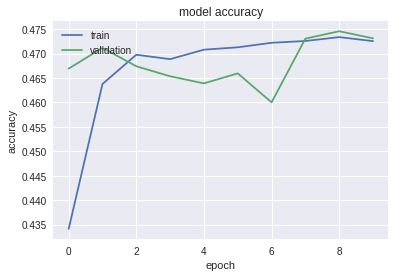

In [34]:
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

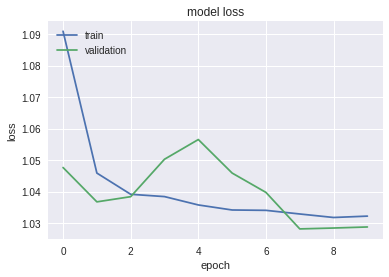

In [35]:
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


2. Measure Model Accuracy for Classification Problem
  - Now we are going to evaluate our model 
  - Accuracy, Recall, F1 Score based on Confusion Matrix
  - Refer definition of each scores
    - Confusion matrix https://en.wikipedia.org/wiki/Confusion_matrix
    - Confusion matrix in Korean https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/
    
  - Hint
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [36]:
from sklearn.metrics import classification_report
print(classification_report(predictions, test_y))


             precision    recall  f1-score   support

          0       0.06      0.40      0.10       202
          1       0.82      0.47      0.59      3600
          2       0.25      0.35      0.29      1025

avg / total       0.66      0.44      0.51      4827



In [37]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions, test_y))

[[  80   43   79]
 [ 932 1674  994]
 [ 338  332  355]]


3. Measure Test Set Return based on the Simplest Strategy
  - Condition
    - Initial budget = 100
 - Strategy
    - If we predict up, then buy or hold (if we already bought)
    - If we predict down or no change then sell (if we already bought) or do nothing 
  - Draw your return

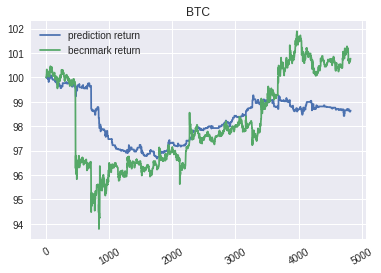

In [38]:
for currency_target in currency_targets:
    bechmark_return = 100
    bechmark_return_history = []

    prediction_return = 100
    prediction_return_history = []

    buy_price = 0
    sell_price = 0
    
    hold = False
    
    test_main_df[currency_target+'-USD-FUTURE_close'] = test_main_df[currency_target+'-USD_close'].shift(-1)
    test_main_df[currency_target+'-USD-RETURN'] = (test_main_df[currency_target+'-USD-FUTURE_close'] 
                                                                - test_main_df[currency_target+'-USD_close'])/test_main_df[currency_target+'-USD_close']
    
    for prediction, (i, r) in zip(predictions, test_main_df.iloc[SEQ_LEN-1:].iterrows()):
        
        if hold == True:
            prediction_return = prediction_return*(1+r[currency_target+'-USD-RETURN'])  
            
        bechmark_return = bechmark_return*(1+r[currency_target+'-USD-RETURN'])
        bechmark_return_history.append(bechmark_return)
        prediction_return_history.append(prediction_return)

        if prediction ==2:
            hold = True
        else: 
            hold = False
    
    plt.title(currency_target)
    plt.plot(prediction_return_history, label = 'prediction return')    
    plt.plot(bechmark_return_history, label = 'becnmark return')
    plt.xticks(rotation=30)
    plt.legend()

# Exercise2 Performance Evaluation for Return Prediction Model

#### Requirements
1. Comparing loss for both Train and Validation set data
  - Compare loss according to the below materials
  - Visualize training history  
  - Check genelarization of your model
  - Refer
    - https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589
  - Visualization Hint
    - https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
2. Measure Model Accuracy for Continuous Value
  - Change Your Prediction Values into Up / Down Binary Variable
  - After then do the same things as in Exercise 1
    - Accuracy, Recall, F1 Score based on Confusion Matrix
    - Refer definition of each scores
      - Confusion matrix https://en.wikipedia.org/wiki/Confusion_matrix
      - Confusion matrix in Korean https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/
  - Hint
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
    
3. Measure Test Set Return based on the Simplest Strategy
  - Condition
    - Initial budget = 100
  - Strategy
    - If we predict up, then buy or hold (if we already bought)
    - If we predict down, then sell (if we already bought) or do nothing 
  - Draw your return

#### Procedures
- Preprocessing
  1. Data Import and Create Balanced Panel
  2. Create Target Variable
  3. Train / Test Split
  4. Create Sequences
  
- Training / Predicting Model
  1. Model Build
  2. Model Train
  3. Prediction
  4. Evaluation

In [0]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "LTC-USD"

## Preprocessing

### 1. Data Import and Create Balanced Panel

In [115]:
import pandas as pd
from sklearn import preprocessing 

main_df = pd.DataFrame() # begin empty

ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]  # the 4 ratios we want to consider

for ratio in ratios:  # begin iteration
  print(ratio)
  dataset = DATA_PATH+f'crypto_data/{ratio}.csv'  # get the full path to the file.
  df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file

  # rename volume and close to include the ticker so we can still which close/volume is which:
  df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)

  df.set_index("time", inplace=True)  # set time as index so we can join them on this shared time
  df = df[[f"{ratio}_close", f"{ratio}_volume"]]  # ignore the other columns besides price and volume

  if len(main_df)==0:  # if the dataframe is empty
      main_df = df  # then it's just the current df
  else:  # otherwise, join this data to the main one
      main_df = main_df.join(df)

main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)
print(main_df.head())  # how did we do??

BTC-USD
LTC-USD
BCH-USD
ETH-USD
            BTC-USD_close  BTC-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1528968720    6487.379883        7.706374      96.660004      314.387024   
1528968780    6479.410156        3.088252      96.570000       77.129799   
1528968840    6479.410156        1.404100      96.500000        7.216067   
1528968900    6479.979980        0.753000      96.389999      524.539978   
1528968960    6480.000000        1.490900      96.519997       16.991997   

            BCH-USD_close  BCH-USD_volume  ETH-USD_close  ETH-USD_volume  
time                                                                      
1528968720     870.859985       26.856577      486.01001       26.019083  
1528968780     870.099976        1.124300      486.00000        8.449400  
1528968840     870.789978        1.749862      485.75000       26.994646  
1528968900     870.000000        1.680500      486.00000    

### 2. Create Target Variable

In [0]:
import numpy as np

currency_targets = ["BTC"]

for currency_target in currency_targets:
  main_df[currency_target+'-USD-TARGET'] = main_df[currency_target+'-USD_close'].shift(-FUTURE_PERIOD_PREDICT )

  # scale up, you can do any other scaling methods!
  # how can we improve this part?
  # hint: reduce noise of future return  
  main_df[currency_target+'-USD-TARGET-RETURN'] = (main_df[currency_target+'-USD-TARGET']-main_df[currency_target+'-USD_close'])/main_df[currency_target+'-USD_close']*100 # scale up
  
  main_df.drop(columns=[currency_target+'-USD-TARGET'], inplace=True)

In [0]:
from sklearn import preprocessing  # pip install sklearn ... if you don't have it!

# Scaling Your Data
main_df.fillna(main_df.mean(), inplace=True)

In [118]:
main_df.head()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,BCH-USD_close,BCH-USD_volume,ETH-USD_close,ETH-USD_volume,BTC-USD-TARGET-RETURN
time,,,,,,,,,
1528968720,6487.379883,7.706374,96.660004,314.387024,870.859985,26.856577,486.01001,26.019083,-0.114066
1528968780,6479.410156,3.088252,96.570000,77.129799,870.099976,1.124300,486.00000,8.449400,0.009103
1528968840,6479.410156,1.404100,96.500000,7.216067,870.789978,1.749862,485.75000,26.994646,-0.033798
1528968900,6479.979980,0.753000,96.389999,524.539978,870.000000,1.680500,486.00000,77.355759,0.000309
1528968960,6480.000000,1.490900,96.519997,16.991997,869.989990,1.669014,486.00000,7.503300,-0.000151


### 3. Train / Test Split

In [0]:
times = sorted(main_df.index.values)  # get the times
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]  # get the last 5% of the times

test_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%

### 4. Create Sequences

In [0]:
from sklearn import preprocessing  # pip install sklearn ... if you don't have it!
from collections import deque
import random
import numpy as np

def sequence_generator(main_df, SEQ_LEN, suffle=True,seed=101):
    
  sequential_data = []  # this is a list that will CONTAIN the sequences
  queue = deque(maxlen = SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in main_df.values:  # iterate over the values
      queue.append([n for n in i[:-1]])  # store all but the target
      if len(queue) == SEQ_LEN:  # make sure we have 60 sequences!
          sequential_data.append([np.array(queue), i[-1]])  # append those bad boys!

  if suffle == True:
      random.seed(seed)
      random.shuffle(sequential_data)  # shuffle for good measure.

  X = []
  y = []

  for seq, target in sequential_data:  # going over our new sequential data
      X.append(seq)  # X is the sequences
      y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

  return np.array(X), y  # return X and y...and make X a numpy array!

In [0]:
train_x, train_y = sequence_generator(main_df , SEQ_LEN, suffle=True, seed=101)
test_x, test_y = sequence_generator(test_main_df , SEQ_LEN, suffle=True, seed=101)

In [122]:
print(train_x.shape, len(train_y))
print(test_x.shape, len(test_y))

(92778, 60, 8) 92778
(4827, 60, 8) 4827


## Return Prediction Model

### 1. Model Build

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,\
CuDNNLSTM, BatchNormalization, Flatten, Activation

def ex2_models(input_dim, output_dim):

  # you can try your own model!
  
  L1 = 256  # 256
  L2 = 256  # 256
  L3 = 32  # 32

  model = Sequential()
  
  model.add(CuDNNLSTM(L1, input_shape=input_dim, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

  model.add(CuDNNLSTM(L2, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())

  model.add(CuDNNLSTM(L3))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())


  model.add(Flatten())
  model.add(Dense(output_dim))
  model.add(Activation('linear'))

  model.compile(optimizer=tf.train.AdamOptimizer(0.001),
            loss='mean_squared_error')

  return model

### 2. Model Train

In [0]:
model2 = ex2_models(train_x.shape[1:], 1)

In [125]:
BATCH_SIZE = 64 
NUM_ITERATIONS = 10

hist2 = model2.fit(train_x, train_y, 
              validation_split=0.2,                   
              batch_size = BATCH_SIZE,
              epochs = NUM_ITERATIONS)

Train on 74222 samples, validate on 18556 samples
Epoch 1/10
74222/74222 [==============================] - 75s 1ms/step - loss: 0.1224 - val_loss: 0.0239
Epoch 2/10
74222/74222 [==============================] - 72s 965us/step - loss: 0.0237 - val_loss: 0.0238
Epoch 3/10
74222/74222 [==============================] - 72s 972us/step - loss: 0.0236 - val_loss: 0.0243
Epoch 4/10
74222/74222 [==============================] - 71s 962us/step - loss: 0.0236 - val_loss: 0.0243
Epoch 5/10
74222/74222 [==============================] - 71s 962us/step - loss: 0.0236 - val_loss: 0.0241
Epoch 6/10
74222/74222 [==============================] - 72s 972us/step - loss: 0.0236 - val_loss: 0.0241
Epoch 7/10
74222/74222 [==============================] - 72s 974us/step - loss: 0.0236 - val_loss: 0.0285
Epoch 8/10
74222/74222 [==============================] - 72s 973us/step - loss: 0.0235 - val_loss: 0.0239
Epoch 9/10
74222/74222 [==============================] - 72s 974us/step - loss: 0.0235 - val_lo

### 3. Prediction

In [126]:
predictions = model2.predict(test_x)

# Score model
score = model2.evaluate(test_x, test_y,
                       verbose=0)

print('Test loss:', score) # this is mean_squared_error 

Test loss: 0.019070454599073004


### 4. Evaluation

1. Comparing Accuracy both Train and Validation set data
  - Compare loss according to the below materials
  - Visualize training history  
  - Check genelarization of your model
  - Refer
    - https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589
  - Visualization Hint
    - https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [127]:
# list all data in history
print(hist2.history.keys())

dict_keys(['val_loss', 'loss'])


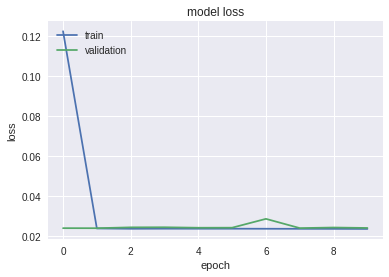

In [138]:
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

    
2. Measure Model Accuracy for Continuous Value
  - Change Your Prediction Values into Up / Down Binary Variable
  - After then do the same things as in Exercise 1
    - Accuracy, Recall, F1 Score based on Confusion Matrix
    - Refer definition of each scores
      - Confusion matrix https://en.wikipedia.org/wiki/Confusion_matrix
      - Confusion matrix in Korean https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/
  - Hint
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html      

In [0]:
predictions_binary = [1 if prediction >0 else 0 for prediction in predictions]
test_y_binary = [1 if y >0 else 0 for y in test_y]

In [140]:
from sklearn.metrics import classification_report
print(classification_report(predictions_binary, test_y_binary))

             precision    recall  f1-score   support

          0       1.00      0.53      0.70      4812
          1       0.00      0.47      0.01        15

avg / total       0.99      0.53      0.69      4827



In [141]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions_binary, test_y_binary))

[[2572 2240]
 [   8    7]]


3. Measure Test Set Return based on the Simplest Strategy
  - Condition
    - Initial budget = 100
  - Strategy
    - If we predict up, then buy or hold (if we already bought)
    - If we predict down, then sell (if we already bought) or do nothing 
  - Draw your return


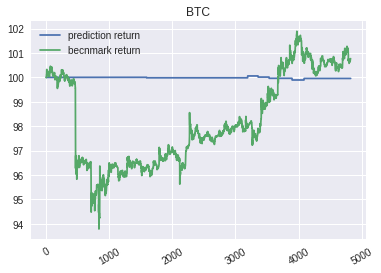

In [142]:
for currency_target in currency_targets:
    bechmark_return = 100
    bechmark_return_history = []

    prediction_return = 100
    prediction_return_history = []

    buy_price = 0
    sell_price = 0
    
    hold = False
    
    test_main_df[currency_target+'-USD-FUTURE_close'] = test_main_df[currency_target+'-USD_close'].shift(-1)
    test_main_df[currency_target+'-USD-RETURN'] = (test_main_df[currency_target+'-USD-FUTURE_close'] 
                                                                - test_main_df[currency_target+'-USD_close'])/test_main_df[currency_target+'-USD_close']
    
    for prediction, (i, r) in zip(predictions, test_main_df.iloc[SEQ_LEN-1:].iterrows()):
        
        if hold == True:
            prediction_return = prediction_return*(1+r[currency_target+'-USD-RETURN'])  
            
        bechmark_return = bechmark_return*(1+r[currency_target+'-USD-RETURN'])
        bechmark_return_history.append(bechmark_return)
        prediction_return_history.append(prediction_return)

        if prediction >0:
            hold = True
        else: 
            hold = False
    
    plt.title(currency_target)
    plt.plot(prediction_return_history, label = 'prediction return')    
    plt.plot(bechmark_return_history, label = 'becnmark return')
    plt.xticks(rotation=30)
    plt.legend()

### How can we improve the performance?

- add volatility forecasting (predict both return and volatility) and custom loss function

- reduce the noise of future return
- normalize input features
- hyperparameter search

- etc